# OCT Post-processing

Demostrates using regression techniques to produce OCT boundary estimates from dense (per-pixel) CNN estimates.


In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

import GPy                       # provides Gaussian process implementation - you will have to install this

sys.path.append('../..')
import cnn_tools as ct
import train_oct
import postproc_oct as ppo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data

We begin by loading some dense estimates that were computed remotely.  At this point in the processing chain we are finished with CNNs and Keras; the remaining calculations are just vanilla linear algebra.

In [2]:
f = np.load('PID6882_oct_seg_fold0_deploy_final.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices and x not in valid_slices]

print('X shape:     ', X.shape)
print('Y shape:     ', Y.shape)
print('Y_hat shape: ', Y_hat.shape)
print('test slices are: ', test_slices)

X shape:      (50, 1, 512, 768)
Y shape:      (50, 1, 512, 768)
Y_hat shape:  (50, 512, 768)
test slices are:  [0 1 2 3 4]


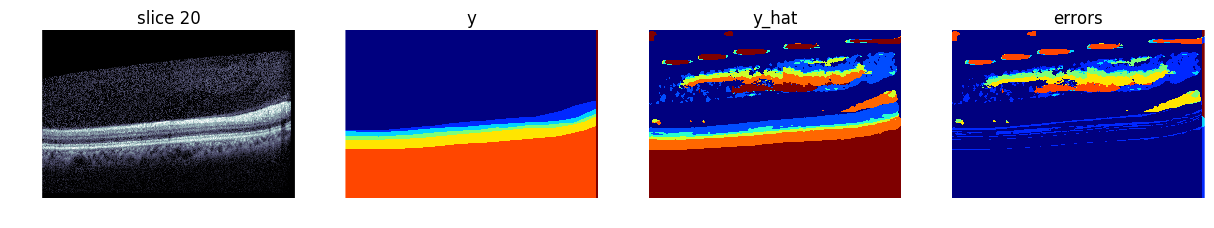

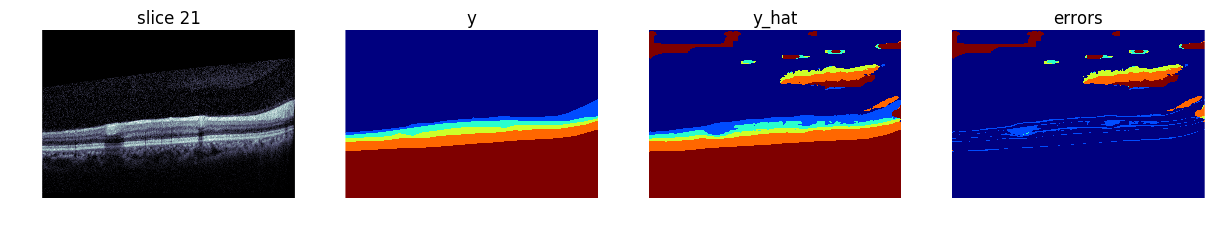

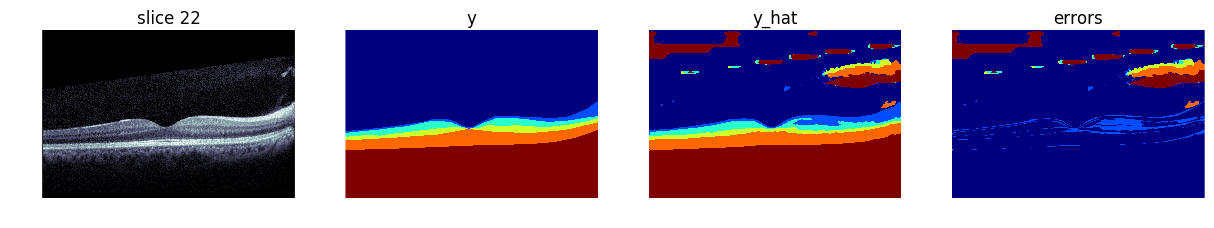

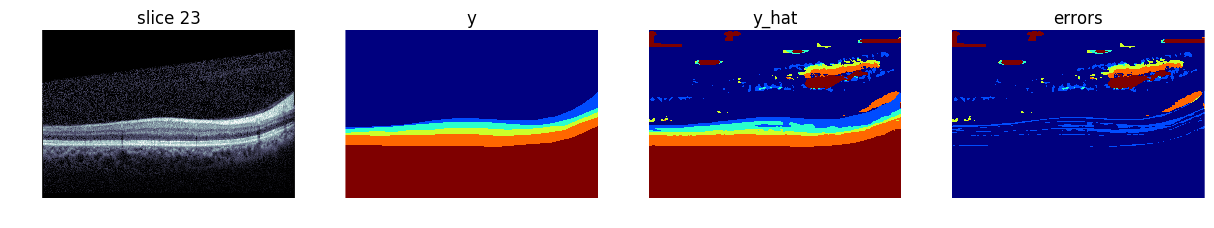

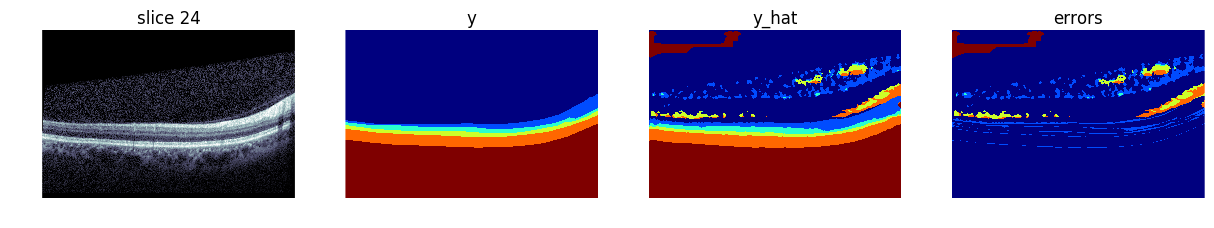

In [3]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

# Regression demonstration

In [9]:
# Compute estimates using points across entire ensemble of models.
# We'll do the computation in this cell, and analysis in another
# (it takes a little while to compute all the estimates)

n_boundaries = 5
x_eval = np.arange(X.shape[-1])
Y_hat_all = np.zeros((X.shape[0], n_boundaries, X.shape[-1]))  #  (image, boundary_id, columns)

for img_idx in test_slices:
    for boundary_idx in range(n_boundaries):
        estimates = ppo.get_class_transitions(Y_hat[img_idx,:,:], boundary_idx)
    
        # TODO: hyperparameter selection!
        if boundary_idx >= 4:
            kern = GPy.kern.RBF(input_dim=1, variance=5, lengthscale=100)
        else:
            kern = GPy.kern.RBF(input_dim=1, variance=20, lengthscale=80)

        tic = time.time()
        y_hat = ppo.boundary_regression_1d(estimates[:,1], estimates[:,0], x_eval, kern)
        Y_hat_all[img_idx, boundary_idx, :] = np.squeeze(y_hat)
        print('runtime for image %d, boundary %d: %0.2f sec' % (img_idx, boundary_idx, time.time() - tic))

np.savez('final_estimates.npz', Y_hat_all=Y_hat_all)
savemat('final_estimates.mat', {'Y_hat' : Y_hat_all})
print('done!')

runtime for image 0, boundary 0: 0.76 sec
runtime for image 0, boundary 1: 0.31 sec
runtime for image 0, boundary 2: 0.26 sec
runtime for image 0, boundary 3: 0.17 sec
runtime for image 0, boundary 4: 0.16 sec
runtime for image 1, boundary 0: 1.16 sec
runtime for image 1, boundary 1: 0.47 sec
runtime for image 1, boundary 2: 0.48 sec
runtime for image 1, boundary 3: 0.34 sec
runtime for image 1, boundary 4: 0.12 sec
runtime for image 2, boundary 0: 1.18 sec
runtime for image 2, boundary 1: 0.39 sec
runtime for image 2, boundary 2: 0.54 sec
runtime for image 2, boundary 3: 0.28 sec
runtime for image 2, boundary 4: 0.12 sec
runtime for image 3, boundary 0: 0.90 sec
runtime for image 3, boundary 1: 0.31 sec
runtime for image 3, boundary 2: 0.43 sec
runtime for image 3, boundary 3: 0.27 sec
runtime for image 3, boundary 4: 0.13 sec
runtime for image 4, boundary 0: 1.25 sec
runtime for image 4, boundary 1: 0.34 sec
runtime for image 4, boundary 2: 0.73 sec
runtime for image 4, boundary 3: 0